# Cardiovascular Disease Prediction
Cardiovascular Study Dataset: The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.
Each attribute is a potential risk factor. There are both demographic, behavioral and medical risk factors.

Main Question of Analysis:
***What are the key predictors of the 10-year risk of coronary heart disease (CHD) among the given demographic, behavioral, and medical variables?***

Demographics and Risk:
- How does age or sex impact the 10-year risk of CHD?
- Are there noticeable trends in age or sex distribution among those at risk?

Behavioral Factors:
- Does smoking status correlate with higher cholesterol, blood pressure, or glucose levels?
- How does the number of cigarettes per day impact these health indicators?

Medical History and Current Conditions:
- Is there a stronger association between certain medical history factors (e.g., diabetes, hypertension) and the risk of CHD?
- How do current medical measurements (e.g., BMI, glucose) differ between those at risk and those not at risk?

# Importing Libaries

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (root_mean_squared_error, classification_report, roc_auc_score, 
                             roc_curve, precision_recall_curve, confusion_matrix, accuracy_score)
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from scipy.stats import zscore, norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import ttest_ind


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


# Data Loading and Cleaning

In [3]:
file_path = 'train.csv'
df = pd.read_csv(file_path)
df.shape

(3390, 17)

Data overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [5]:
df.head(10)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0
5,5,61,3.0,F,NO,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1
6,6,61,1.0,M,NO,0.0,0.0,0,1,0,238.0,232.0,136.0,24.83,75.0,79.0,0
7,7,36,4.0,M,YES,35.0,0.0,0,0,0,295.0,102.0,68.0,28.15,60.0,63.0,0
8,8,41,2.0,F,YES,20.0,NaN,0,0,0,220.0,126.0,78.0,20.70,86.0,79.0,0
9,9,55,2.0,F,NO,0.0,0.0,0,1,0,326.0,144.0,81.0,25.71,85.0,NaN,0


In [6]:
df['sex'] = df['sex'].map({'F': 1, 'M': 0})
df.rename(columns={'sex': 'is_female'}, inplace=True)

df['is_smoking'] = df['is_smoking'].map({'YES': 1, 'NO': 0})

In [7]:
df.describe()

,id,age,education,is_female,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3390.000000,3390.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,0.567257,0.497640,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,0.495529,0.500068,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,1.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,1.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


### Dublicates and missing values

This section will be checking missing values, dublicates and drops unnessecary columns

In [8]:
df_train=df.copy()

In [9]:
def clean_data(df_train):
 
    missing_count = df_train.isnull().sum().sum()
    duplicate_count = df_train.duplicated().sum()  

    if 'Unnamed: 0' in df_train.columns:
        df_train.drop(columns=['Unnamed: 0'], inplace=True)
        print("Dropped column: 'Unnamed: 0'.")
    
    print(f"Missing values in dataset: {missing_count}")
    print(f"Duplicate rows in dataset: {duplicate_count}")

    return df_train

df_train = clean_data(df_train)

Missing values in dataset: 510
Duplicate rows in dataset: 0


There are several missing values in dataset and needs futher investigation.

In [10]:
def show_missing():
    missing = df_train.columns[df_train.isnull().any()].tolist()
    return missing

print('Missing Data Count')
print(df_train[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*15)
print('Missing Data Percentage')
print(round(df_train[show_missing()].isnull().sum().sort_values(ascending = False)/len(df_train)*100,2))

Missing Data Count
glucose       304
education      87
BPMeds         44
totChol        38
cigsPerDay     22
BMI            14
heartRate       1
dtype: int64
------------------------------
Missing Data Percentage
glucose       8.97
education     2.57
BPMeds        1.30
totChol       1.12
cigsPerDay    0.65
BMI           0.41
heartRate     0.03
dtype: float64


### Handling Missing Values and Outliers in the Dataset:
Imputation: Missing values are replaced with the average of the nearest neighbors.
Outlier Removal: Rows with extreme values (outliers) based on Z-scores are removed.
The final dataset is cleaned and ready for further analysis or modeling.

In [11]:
imputer = KNNImputer(n_neighbors=5)
df_train_copy = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)

categorical_cols = ['education', 'BPMeds', 'is_female', 'is_smoking', 'prevalentStroke', 
                    'prevalentHyp', 'diabetes', 'TenYearCHD']
df_train_copy[categorical_cols] = df_train_copy[categorical_cols].astype(int)

threshold = 3
outlier_cols = ['cigsPerDay', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']

z_scores = stats.zscore(df_train_copy[outlier_cols])

z_scores_df = pd.DataFrame(z_scores, columns=outlier_cols, index=df_train_copy.index)

outliers = (z_scores_df > threshold) | (z_scores_df < -threshold)

mask = (~outliers).all(axis=1)
df_train_copy = df_train_copy[mask]

print(f"Missing values after replacement: {df_train_copy.isnull().sum().sum()}")
print("Number of rows after outlier removal:", df_train_copy.shape[0])

Missing values after replacement: 0
Number of rows after outlier removal: 3220


In [12]:
df_train_copy.head(10)

,id,age,education,is_female,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0.0,64.0,2,1,1,3.0,0,0,0,0,221.0,148.0,85.0,25.858,90.0,80.0,1
1,1.0,36.0,4,0,0,0.0,0,0,1,0,212.0,168.0,98.0,29.770,72.0,75.0,0
2,2.0,46.0,1,1,1,10.0,0,0,0,0,250.0,116.0,71.0,20.350,88.0,94.0,0
3,3.0,50.0,1,0,1,20.0,0,0,1,0,233.0,158.0,88.0,28.260,68.0,94.0,1
4,4.0,64.0,1,1,1,30.0,0,0,0,0,241.0,136.5,85.0,26.420,70.0,77.0,0
5,5.0,61.0,3,1,0,0.0,0,0,1,0,272.0,182.0,121.0,32.800,85.0,65.0,1
7,7.0,36.0,4,0,1,35.0,0,0,0,0,295.0,102.0,68.0,28.150,60.0,63.0,0
8,8.0,41.0,2,1,1,20.0,0,0,0,0,220.0,126.0,78.0,20.700,86.0,79.0,0
9,9.0,55.0,2,1,0,0.0,0,0,1,0,326.0,144.0,81.0,25.710,85.0,75.6,0
10,10.0,61.0,1,1,0,0.0,0,0,1,0,241.0,185.0,121.0,35.220,80.0,74.4,0


# Exploratory Data Analysis

Demographics and Risk:
- How does age or sex impact the 10-year risk of CHD?
- Are there noticeable trends in age or sex distribution among those at risk?

Behavioral Factors:
- Does smoking status correlate with higher cholesterol, blood pressure, or glucose levels?
- How does the number of cigarettes per day impact these health indicators?

Medical History and Current Conditions:
- Is there a stronger association between certain medical history factors (e.g., diabetes, hypertension) and the risk of CHD?
- How do current medical measurements (e.g., BMI, glucose) differ between those at risk and those not at risk?

### **Demografics and Risks**
Overview about demografics and risks, focusing on questions:
- How does age or sex impact the 10-year risk of CHD?
- Are there noticeable trends in age or sex distribution among those at risk?

Distribution of Age and Sex in the Dataset

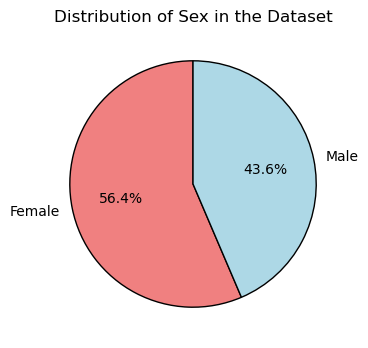

Dataset contains 1817 females.
Dataset contains 1403 males.


In [13]:
sex_distribution = df_train_copy['is_female'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(sex_distribution, labels=['Female', 'Male'], autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Sex in the Dataset')
plt.show()

print(f"Dataset contains {sex_distribution[1]} females.")
print(f"Dataset contains {sex_distribution[0]} males.")

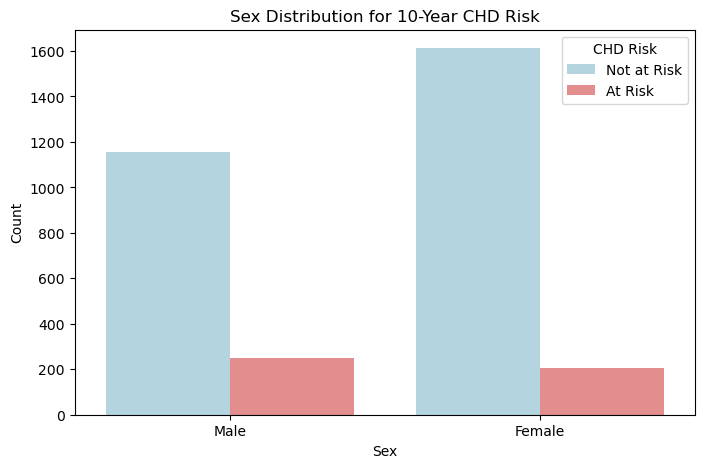

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x='is_female', hue='TenYearCHD', data=df_train_copy, palette={0: 'lightblue', 1: 'lightcoral'})
plt.title('Sex Distribution for 10-Year CHD Risk')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.legend(title='CHD Risk', labels=['Not at Risk', 'At Risk'])
plt.show()

Sex Distribution for 10-Year CHD Risk shows, that men are at bigger CHD risk than women.

Age Distribution for 10-Year CHD Risk

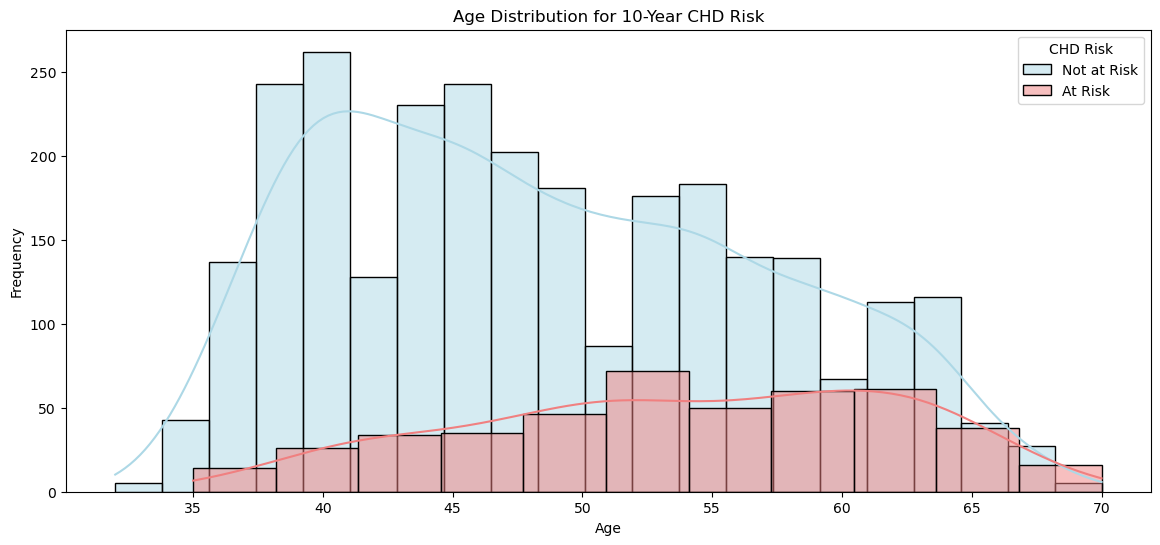

In [15]:
plt.figure(figsize=(14, 6))
sns.histplot(df_train_copy[df_train_copy['TenYearCHD'] == 0]['age'], kde=True, label='Not at Risk', color='lightblue')
sns.histplot(df_train_copy[df_train_copy['TenYearCHD'] == 1]['age'], kde=True, label='At Risk', color='lightcoral')
plt.legend(title='CHD Risk')
plt.title('Age Distribution for 10-Year CHD Risk')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Age correlating with CHD risk over a 10-year period: Majority "Not at Risk": The light blue bars, representing those "Not at Risk" of Coronary Heart Disease (CHD), dominate the histogram, showing a higher frequency compared to the light red bars of those "At Risk."
Peak "Not at Risk" Age Group: The age group with the highest frequency of "Not at Risk" individuals is around 45-50 years.
Increasing Risk with Age: The frequency of individuals "At Risk" increases with age, peaking around 55-60 years.
Density Curves: The density curves indicate that the risk of CHD increases with age, as the density curve for the "At Risk" category shifts towards older ages.

Distribution of Education in the Dataset

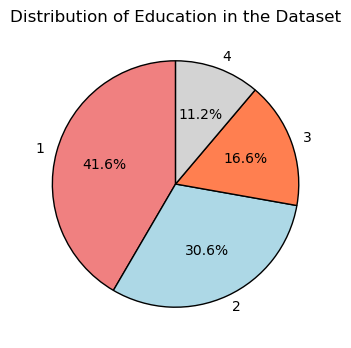

In [16]:
sex_distribution = df_train_copy['education'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(sex_distribution, labels=['1', '2', '3', '4'], autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'coral', 'lightgrey'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Education in the Dataset')
plt.show()

Majority of people has first or secondary education level. 
1 level - 41.6%
2 level - 30.6%
3 level - 16.6%
4 level - 11.2%

Proportion of 10-Year CHD Risk by Education Level

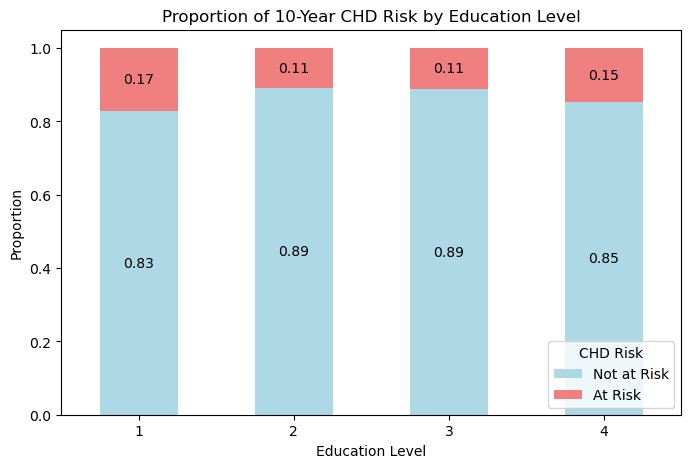

In [17]:
education_risk = df_train_copy.groupby(['education', 'TenYearCHD']).size().unstack().fillna(0)
education_risk_percentage = education_risk.div(education_risk.sum(axis=1), axis=0)
ax=education_risk_percentage.plot(kind='bar', stacked=True, figsize=(8, 5), color=['lightblue', 'lightcoral'])

plt.title('Proportion of 10-Year CHD Risk by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.legend(title='CHD Risk', labels=['Not at Risk', 'At Risk'], loc='lower right')
plt.xticks(rotation=0)
for container in ax.containers:
   ax.bar_label(container, label_type='center', fmt='%.2f')
plt.show()

Visual representation implies that there might be some connection between education level and CHD risk, highlighting the potential importance of educational interventions in public health strategies for reducing CHD risk.
The lowest education level (Level 1) has a higher proportion of individuals "At Risk" (0.17), while the highest education level (Level 4) also has a slightly higher proportion "At Risk" (0.15) compared to Levels 2 and 3.
"The highest education level (Level 4) group also has the smallest representation in the data set, making up only 11%. Therefore, the elevated proportion of individuals 'At Risk' in this group might be coincidental.

Age Distribution by Education Level and CHD Risk

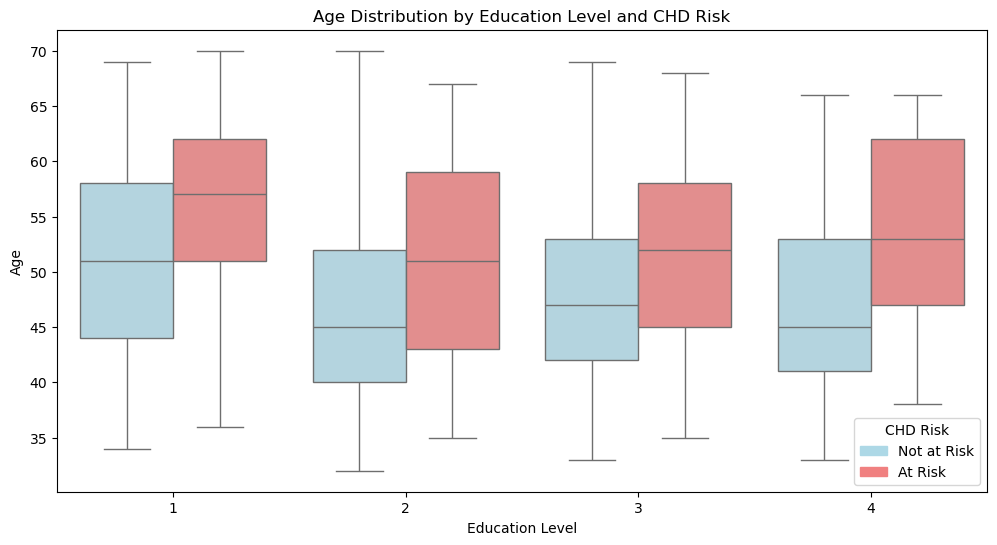

In [18]:
colors = {0: 'lightblue', 1: 'lightcoral'}

plt.figure(figsize=(12, 6))
sns.boxplot(x='education', y='age', hue='TenYearCHD', data=df_train_copy, palette=colors)

plt.title('Age Distribution by Education Level and CHD Risk')
plt.xlabel('Education Level')
plt.ylabel('Age')

legend_patches = [mpatches.Patch(color=colors[0], label='Not at Risk'),
                  mpatches.Patch(color=colors[1], label='At Risk')]

plt.legend(handles=legend_patches, title='CHD Risk')
plt.show()

There are potential age-related trends and disparities in health outcomes based on education level.

- Higher Median Age for CHD Risk: For all education levels, individuals "At Risk" for CHD tend to have a higher median age than those "Not at Risk."
- Broader Age Range: The age range for individuals "At Risk" for CHD is generally wider compared to those "Not at Risk," indicating a greater variability in age among the at-risk population.
- Slight Increase with Education: The median age for both "Not at Risk" and "At Risk" categories appears to slightly increase as the education level goes up.
- Larger Variability in CHD Risk: The interquartile range (IQR) for the "At Risk" category is typically larger than for the "Not at Risk" category, suggesting more variability in age among those at risk.

**Demographics and Risks conclusions**

Sex Impact on CHD Risk:
- Men are at a higher risk of CHD compared to women.

Age Impact on CHD Risk:
- The majority "Not at Risk" are aged 45-50.
- CHD risk increases with age, peaking around 55-60 years.

### **Behavioral Factors**
- Does smoking status correlate with higher cholesterol, blood pressure, or glucose levels?
- How does the number of cigarettes per day impact these health indicators?

Proportion of CHD Risk by Smoking Status

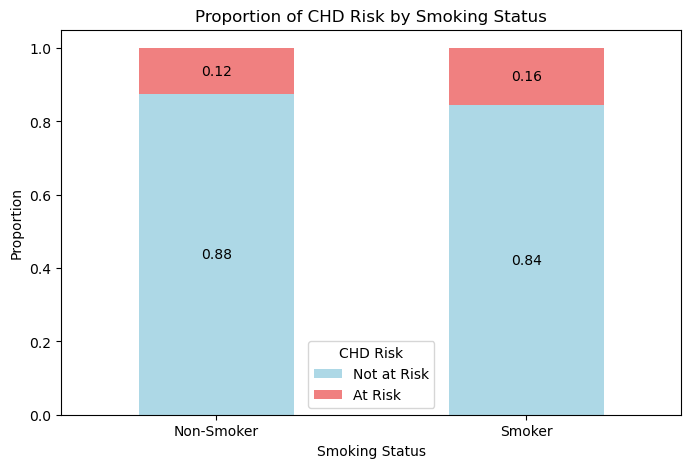

In [19]:
smoking_risk = df_train_copy.groupby(['is_smoking', 'TenYearCHD']).size().unstack().fillna(0)
smoking_risk_percentage = smoking_risk.div(smoking_risk.sum(axis=1), axis=0)

ax = smoking_risk_percentage.plot(kind='bar', stacked=True, figsize=(8, 5), color=['lightblue', 'lightcoral'])

plt.title('Proportion of CHD Risk by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Proportion')
plt.xticks(ticks=[0, 1], labels=['Non-Smoker', 'Smoker'])
plt.xticks(rotation=0)
plt.legend(title='CHD Risk', labels=['Not at Risk', 'At Risk'])

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%.2f')

plt.show()

Chart highlights that smokers have a higher proportion of individuals at risk for CHD compared to non-smokers. This visually demonstrates the increased risk associated with smoking.

Distribution of Cigarettes per Day

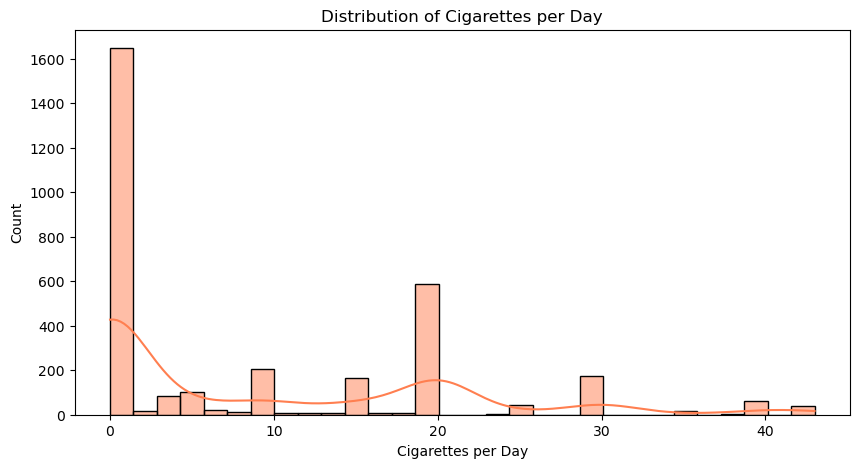

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train_copy['cigsPerDay'], bins=30, kde=True, color='coral')
plt.title('Distribution of Cigarettes per Day')
plt.xlabel('Cigarettes per Day')
plt.ylabel('Count')
plt.show()

Visual highlights the prevalence of non-smokers and the distribution of smoking habits among smokers within the population.
- Majority Non-Smokers: The highest bar is at 0 cigarettes per day, indicating that the majority of people in the dataset do not smoke.
- Distribution Peaks: There are smaller peaks at 10, 20, 30, and 40 cigarettes per day, indicating groups of people who smoke these amounts.
- Density Estimate: The orange line overlays the histogram, representing a smoothed density estimate of the distribution. It shows that the most common smoking frequency is zero, with gradual peaks at certain smoking frequencies.

Well known health indicators by Smoking Status

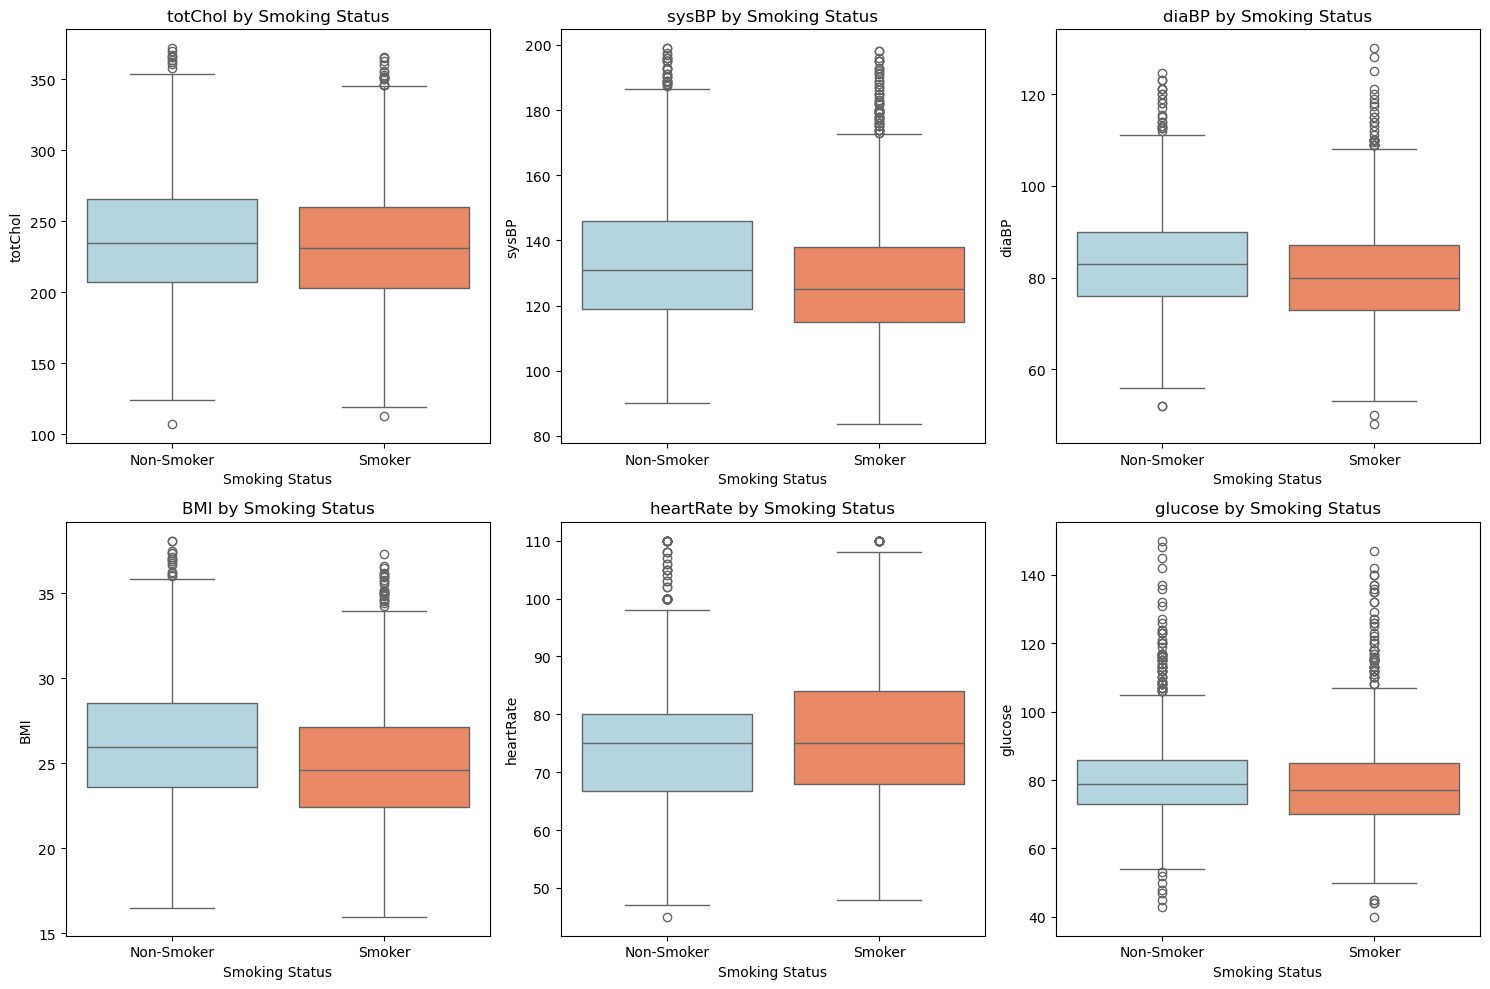

In [21]:
plt.figure(figsize=(15, 10))
health_indicators = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

for i, col in enumerate(health_indicators, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x='is_smoking', y=col, data=df_train_copy, hue='is_smoking', 
                palette=['lightblue', 'coral'], dodge=False)
    plt.title(f'{col} by Smoking Status')
    plt.xlabel('Smoking Status')
    plt.xticks(ticks=[0, 1], labels=['Non-Smoker', 'Smoker'])
    plt.ylabel(col)
    plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

- Higher Health Metrics for Smokers: Smokers generally have higher total cholesterol, systolic and diastolic blood pressure, heart rate, and blood glucose levels compared to non-smokers.
- More Variability: There's greater variability in health metrics among smokers, particularly in total cholesterol and systolic blood pressure.

Well known health indicators vs Cigarettes per Day

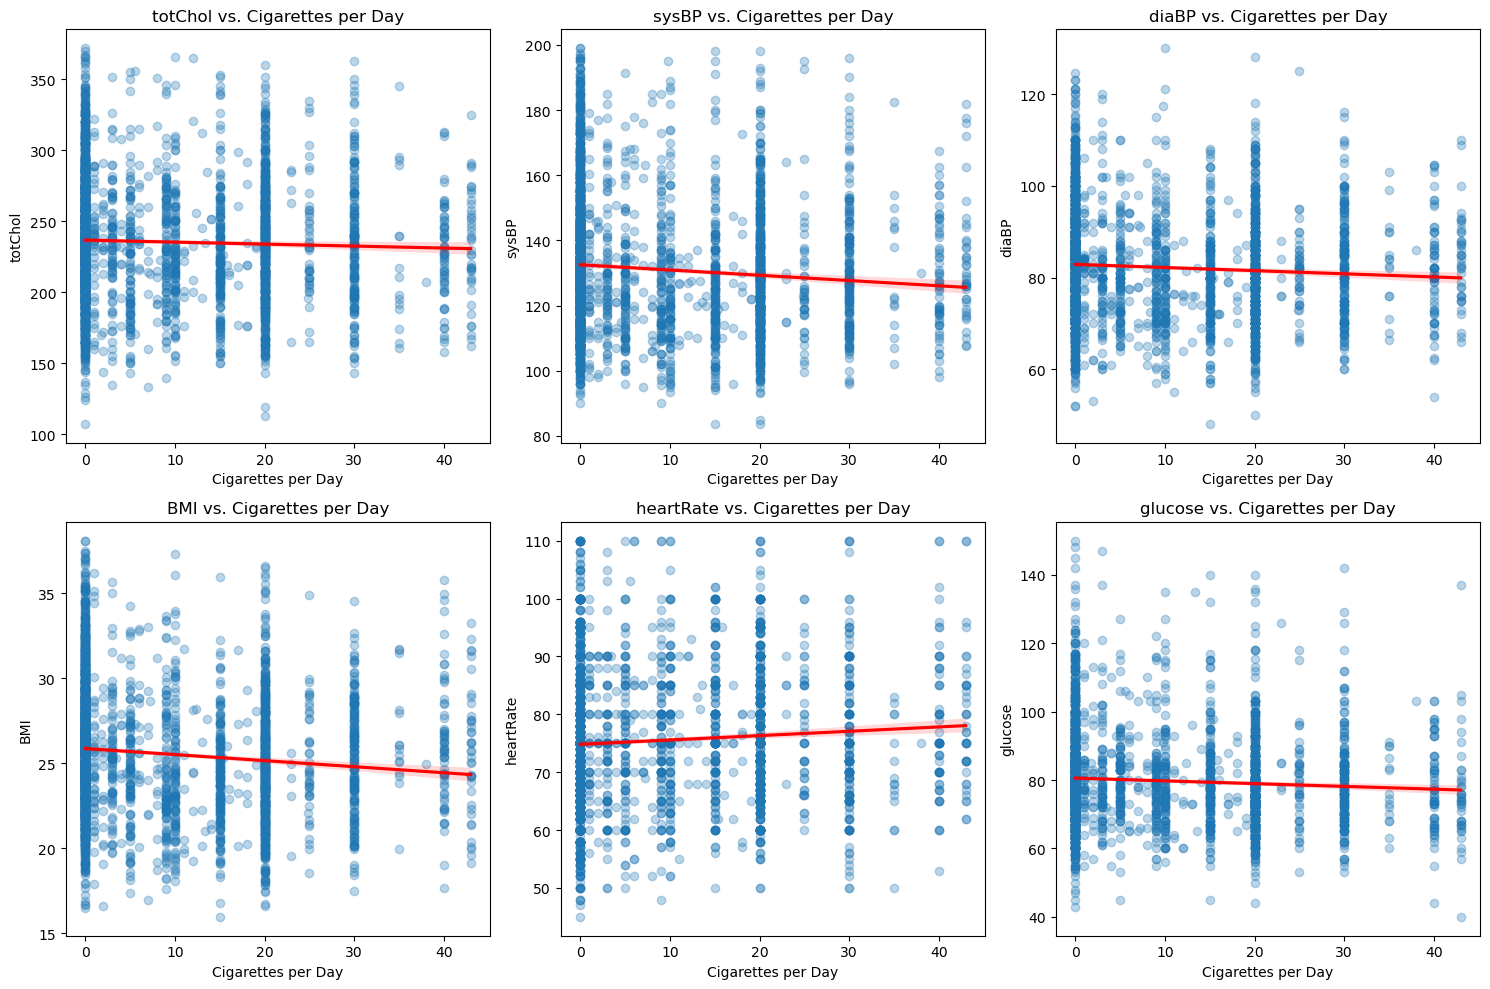

In [22]:
plt.figure(figsize=(15, 10)) 
health_indicators = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

for i, col in enumerate(health_indicators, 1):
    plt.subplot(2, 3, i)
    sns.regplot(x='cigsPerDay', y=col, data=df_train_copy, 
                scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
    plt.title(f'{col} vs. Cigarettes per Day')
    plt.xlabel('Cigarettes per Day')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

- Positive Correlations: Smoking is associated with increased total cholesterol, systolic and diastolic blood pressure, heart rate, and glucose levels.
- BMI: There is no clear trend between BMI and the number of cigarettes smoked.

**Conclusions for behavioral factors**
- Smoking status correlates with higher cholesterol, blood pressure, and glucose levels.
- No significant impact of the number of cigarettes per day on these health indicators is observed in the scatter plots.

### **Medical History and Current Conditions:**
- Is there a stronger association between certain medical history factors (e.g., diabetes, hypertension) and the risk of CHD?
- How do current medical measurements (e.g., BMI, glucose) differ between those at risk and those not at risk?

Medical factors by CHD Risk

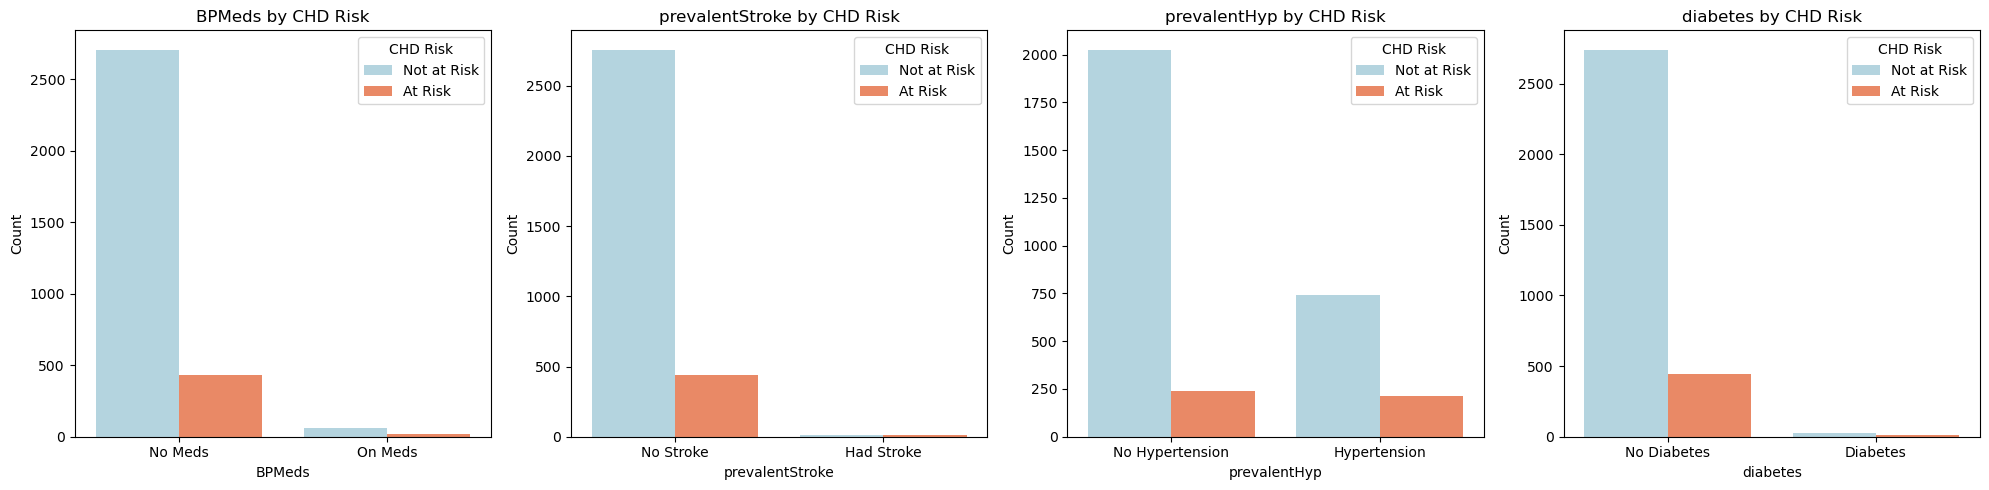

In [23]:
medical_factors = ['BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
factor_labels = {
    'BPMeds': ['No Meds', 'On Meds'],
    'prevalentStroke': ['No Stroke', 'Had Stroke'],
    'prevalentHyp': ['No Hypertension', 'Hypertension'],
    'diabetes': ['No Diabetes', 'Diabetes']
}

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 

for i, factor in enumerate(medical_factors):
    sns.countplot(x=factor, hue='TenYearCHD', data=df_train_copy, palette=['lightblue', 'coral'], ax=axes[i])
    axes[i].set_title(f'{factor} by CHD Risk')
    axes[i].set_xlabel(f'{factor}')
    axes[i].set_ylabel('Count')
    axes[i].legend(title='CHD Risk', labels=['Not at Risk', 'At Risk'])
    
   
    axes[i].set_xticks([0, 1]) 
    axes[i].set_xticklabels(factor_labels[factor])

plt.tight_layout()
plt.show()

Observations from Health Conditions and CHD Risk:
- Most people "Not at Risk" do not take blood pressure medications and have not had a stroke, hypertension, or diabetes.
- Conversely, a significant number of people "At Risk" have hypertension, while fewer are on blood pressure medications, have had a stroke, or diabetes.

Pairplot of Medical Measurements by CHD Risk

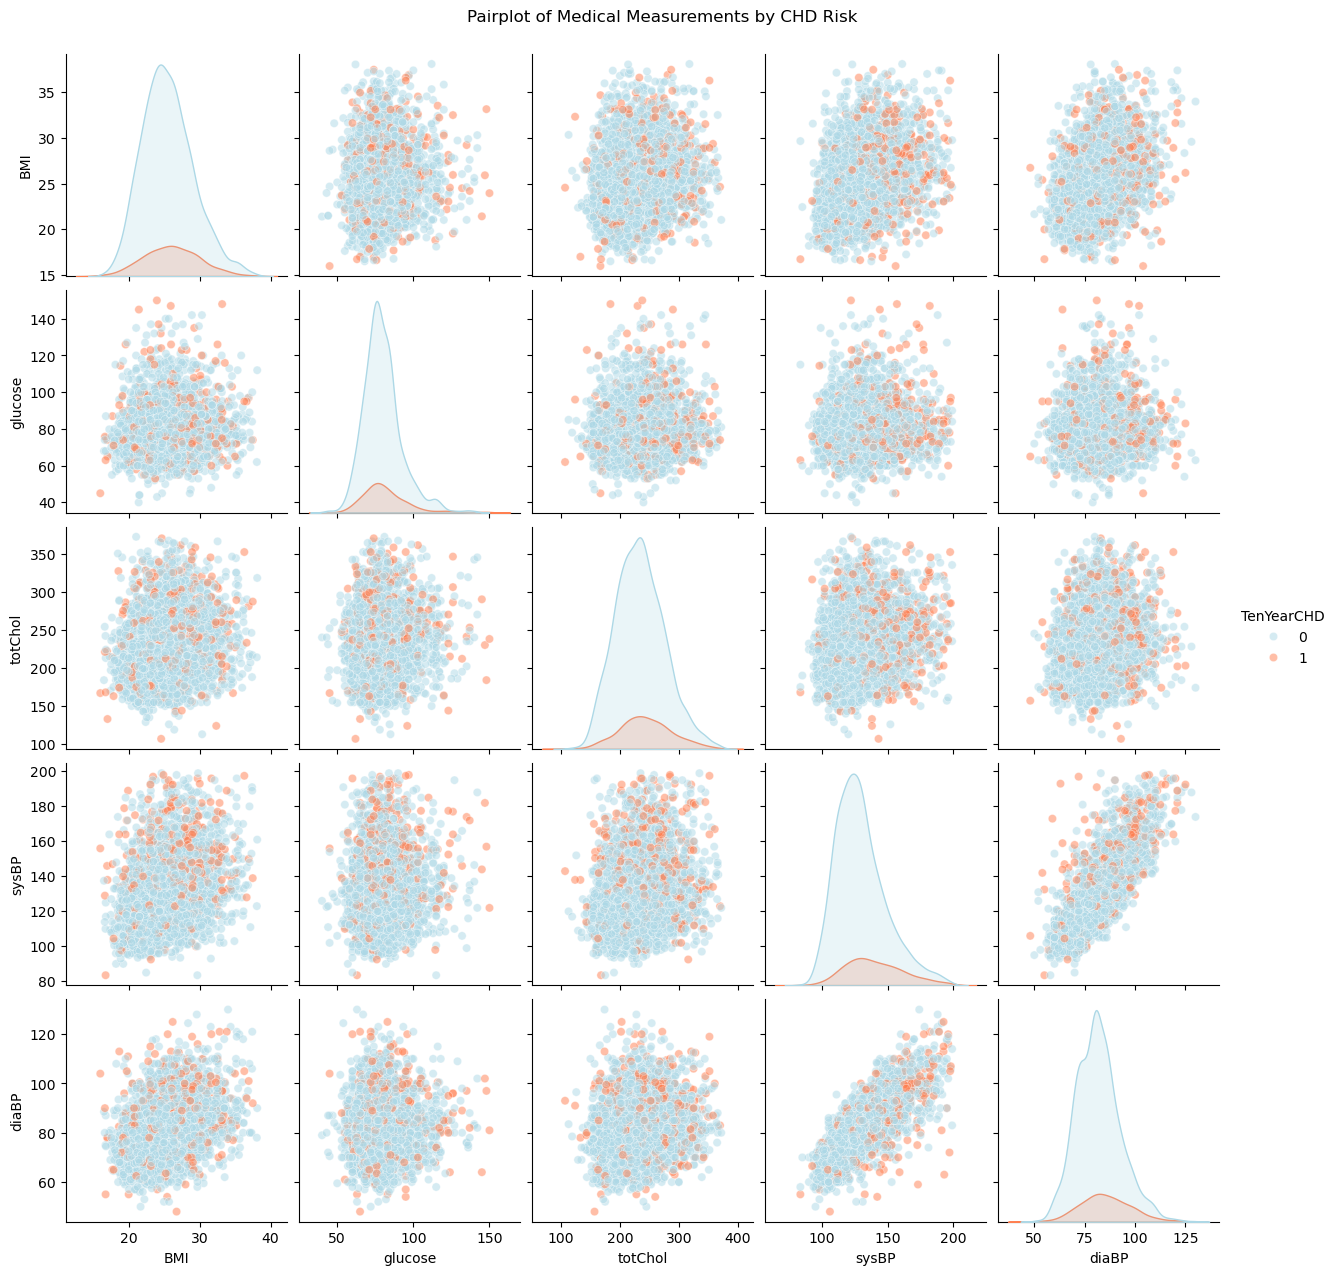

In [24]:
medical_features = ['BMI', 'glucose', 'totChol', 'sysBP', 'diaBP']

g = sns.pairplot(df_train_copy, vars=medical_features, hue='TenYearCHD', palette=['lightblue', 'coral'], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Medical Measurements by CHD Risk', y=1.02)
plt.show()


- Overlapping Points: The red (CHD risk) and blue (no CHD risk) points are largely mixed, making it difficult to separate the two groups just by looking.
- No Clear Clusters: No obvious, distinct clusters indicate a clear separation between at-risk and not-at-risk individuals.
- Need for Further Analysis:
Statistical tests (e.g., t-tests) or machine learning models (e.g., logistic regression) would help quantify relationships better.

### T-test 

In [25]:
medical_features = ['BMI', 'glucose', 'totChol', 'sysBP', 'diaBP']

for col in medical_features:
    at_risk = df_train_copy[df_train_copy['TenYearCHD'] == 1][col].dropna()
    not_at_risk = df_train_copy[df_train_copy['TenYearCHD'] == 0][col].dropna()
    
    t_stat, p_value = ttest_ind(at_risk, not_at_risk, equal_var=False)
    print(f"{col}: t-stat={t_stat:.2f}, p-value={p_value:.4f}")

BMI: t-stat=2.94, p-value=0.0034
glucose: t-stat=2.40, p-value=0.0169
totChol: t-stat=4.31, p-value=0.0000
sysBP: t-stat=9.71, p-value=0.0000
diaBP: t-stat=5.90, p-value=0.0000


These results underscore that individuals at risk for CHD tend to have significantly higher BMI, glucose, total cholesterol, systolic, and diastolic blood pressure levels. This reinforces the importance of monitoring these health indicators in managing and reducing CHD risk.

Correlation Analysis


Strongly Positively Correlated Features:
        Feature_1     Feature_2  Correlation
6     cigsPerDay    is_smoking     0.772261
11  prevalentHyp         sysBP     0.699285
14      diabetes       glucose     0.620211
19         diaBP  prevalentHyp     0.612897
20         diaBP         sysBP     0.781908

There aren't strongly negatively correlated features.


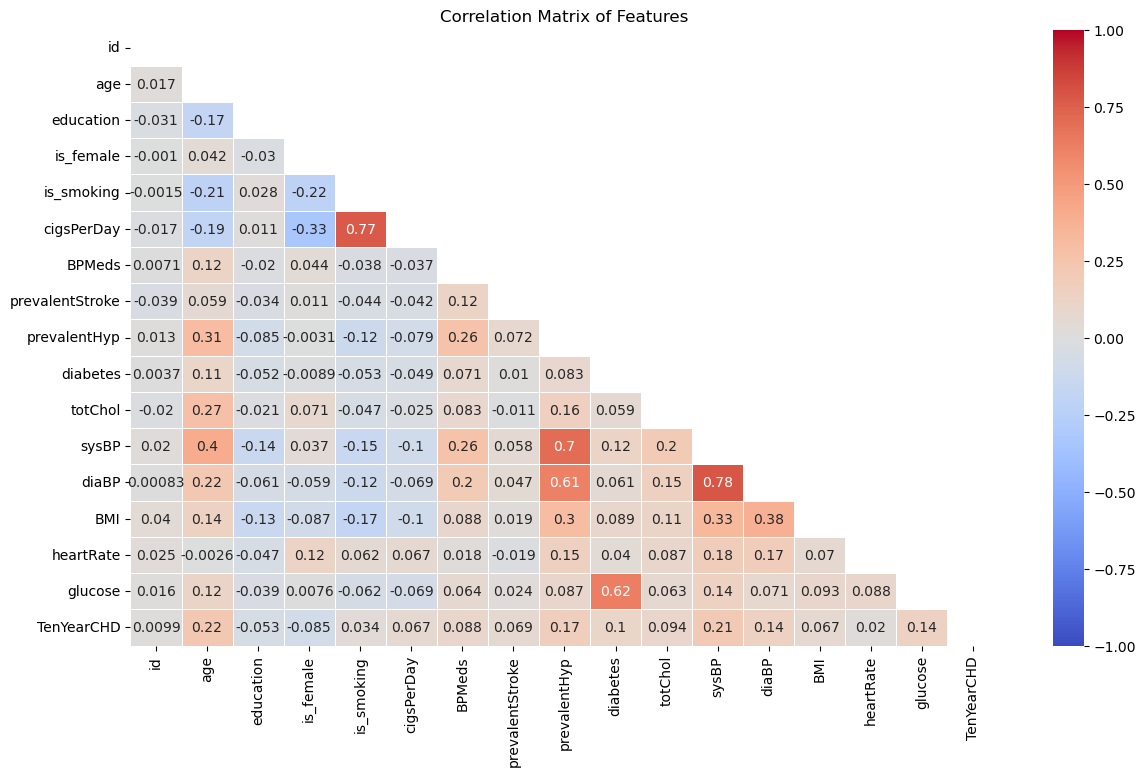

In [26]:
def correlation_analysis(df_train_copy):

    correlation_matrix = df_train_copy.corr(numeric_only=True) #kas education peaks siin sees olema?

    def extract_unique_correlations(corr_matrix, condition):
        """Extract unique correlation pairs based on a condition."""
        correlations = corr_matrix[condition].stack().reset_index()
        correlations.columns = ['Feature_1', 'Feature_2', 'Correlation']
        correlations = correlations[correlations['Feature_1'] != correlations['Feature_2']]
        correlations = correlations[correlations['Feature_1'] < correlations['Feature_2']]
        return correlations

    strong_positive = extract_unique_correlations(correlation_matrix, correlation_matrix > 0.5)
    if strong_positive.empty:
        print("\nThere aren't strongly Positively correlated features.")
    else:
        print("\nStrongly Positively Correlated Features:\n", strong_positive)

    strong_negative = extract_unique_correlations(correlation_matrix, correlation_matrix < -0.5)
    if strong_negative.empty:
        print("\nThere aren't strongly negatively correlated features.")
    else:
        print("\nStrongly Negatively Correlated Features:\n", strong_negative)


    plt.figure(figsize=(14, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask, vmin=-1, vmax=1) 
    plt.title('Correlation Matrix of Features')
    plt.show()

correlation_analysis(df_train)

Hypertension & Blood Pressure (r = 0.70 & 0.61)
 - Prevalent hypertension (prevalentHyp) is strongly linked to systolic (sysBP) and diastolic (diaBP) blood pressure, which makes sense because hypertension is defined by high blood pressure.
 
 Diabetes & Glucose (r = 0.62)
 - People with higher glucose levels are more likely to have diabetes.
 
 Smoking & Cigarettes per Day (r = 0.77)
  - Strong correlation makes sense because smoking status is naturally linked to the number of cigarettes smoked per day. 

Glucose distributions between diabetics and non-diabetics

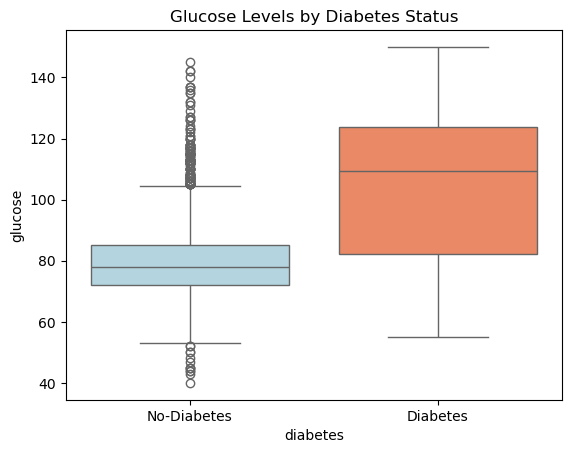

In [27]:
ax = sns.boxplot(x='diabetes', y='glucose', hue='diabetes', data=df_train_copy, palette=['lightblue', 'coral'], legend=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['No-Diabetes', 'Diabetes'])
plt.title('Glucose Levels by Diabetes Status')
plt.show()

- Higher Glucose Levels in Diabetics: Individuals with diabetes have significantly higher glucose levels compared to those without diabetes, as indicated by the higher median and interquartile range (IQR) in the "Diabetes" category.
- No Overlap: The IQRs of the two groups do not overlap, clearly showing a distinction in glucose levels between individuals with and without diabetes.
- Outliers in Non-Diabetics: There are several outliers in the "No-Diabetes" group, with glucose levels both above and below the whiskers, highlighting some variability in glucose levels among non-diabetics.

Rankings of Correlation with CHD risk

In [28]:
df_train_copy.corr()['TenYearCHD'].sort_values(ascending=False)

TenYearCHD         1.000000
age                0.214193
sysBP              0.183126
prevalentHyp       0.151248
diaBP              0.113104
totChol            0.079042
cigsPerDay         0.076741
prevalentStroke    0.070467
BPMeds             0.056148
BMI                0.054296
glucose            0.048197
is_smoking         0.044983
diabetes           0.038627
id                 0.013585
heartRate          0.007341
education         -0.046906
is_female         -0.092056
Name: TenYearCHD, dtype: float64

- Age and CHD Risk: Older individuals have a higher risk of CHD (r = 0.21).
- Blood Pressure: Hypertension is a major risk factor for CHD.
- Cholesterol and Smoking: Total cholesterol (r = 0.079) and cigarettes per day (r = 0.076) have weak positive correlations with CHD risk, likely due to smoking's indirect effects.
- Diabetes and Glucose: Both have weak correlations with CHD risk (Diabetes r = 0.038, Glucose r = 0.048).
- Education and Gender: Higher education (r = -0.047) and being female (r = -0.092) are associated with lower CHD risk

**Medical History and Current Conditions conclusions**

Based on the analysis, hypertension stands out as a significant medical history factor associated with a higher risk of CHD. The data indicates that individuals with hypertension exhibit a strong correlation with both systolic and diastolic blood pressure, making it a key predictor of CHD risk. In contrast, diabetes shows a weaker correlation with CHD risk, suggesting its impact is less pronounced in this context.

When examining current medical measurements, the analysis reveals that individuals "At Risk" for CHD generally present higher blood pressure and glucose levels compared to those "Not at Risk." However, there is no notable difference in BMI between the two groups. These findings highlight the importance of monitoring blood pressure and glucose levels in assessing CHD risk.

Overall, the analysis underscores the need for further statistical tests or machine learning models to better quantify the relationships between these medical factors and CHD risk.


**Key Predictors of 10-Year CHD Risk**

- Demographics and Risks:
    - Sex Impact: Men are at a higher risk of CHD compared to women.
    - Age Impact: CHD risk increases with age, peaking around 55-60 years. The majority "Not at Risk" are aged 45-50.

- Behavioral Factors:
    - Smoking Status: Correlates with higher cholesterol, blood pressure, and glucose levels. The number of cigarettes per day does not significantly impact these health indicators.

- Medical History and Current Conditions:
    - Hypertension: Stands out as a significant medical history factor associated with a higher risk of CHD, with strong correlations observed with both systolic and diastolic blood pressure.
    - Diabetes: Shows a weaker correlation with CHD risk.
    - Health Measurements: Individuals "At Risk" for CHD generally have higher blood pressure and glucose levels, with no notable difference in BMI between the two groups.

Overall, your analysis highlights the importance of sex, age, smoking status, hypertension, and glucose levels as key predictors of CHD risk. Further statistical tests or machine learning models are recommended to better quantify these relationships.

# Logistic Regression

Logistic Regression: Since target variable (10-year risk of CHD) is binary, logistic regression is a suitable choice.
Spliting the data into training and testing sets to evaluate the model's performance.

### Model 1 - Base Logistic Regression

This model uses logistic regression with various demographic and health-related features.

In [29]:
columns_to_scale = ['BMI', 'glucose', 'totChol', 'sysBP', 'diaBP']

df_train_finalcopy = df_train_copy.copy() 

In [30]:
y = df_train_finalcopy['TenYearCHD']
X = df_train_finalcopy[['age', 'education', 'is_female', 'cigsPerDay', 
                        'BPMeds', 'prevalentStroke', 'prevalentHyp', 
                        'diabetes', 'totChol', 'sysBP', 'BMI',
                        'heartRate', 'glucose','diaBP']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

(2576, 14)
(644, 14)


Handling missing values (imputation on train only, transform test) and then Standardize features (fit on train, transform test)

In [31]:
imputer = SimpleImputer(strategy="median")
X_train[columns_to_scale] = imputer.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = imputer.transform(X_test[columns_to_scale])

In [32]:
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [33]:
log_reg_v1 = LogisticRegression(max_iter=5000)

log_reg_v1.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [34]:
X_train_sm = sm.add_constant(X_train)

log_reg_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)

intercept = log_reg_v1.intercept_[0]
coefficients = np.concatenate(([intercept], log_reg_v1.coef_.flatten()))

standard_errors = np.sqrt(np.diag(log_reg_sm.cov_params()))

t_values = coefficients / standard_errors

p_values = [2 * (1 - norm.cdf(np.abs(t_val))) for t_val in t_values]

summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + X_train.columns.tolist(),
    'Coefficient': coefficients,
    'Standard Error': standard_errors,
    't-value': t_values,
    'p-value': p_values
})
summary_table = summary_table.round(2)
print(summary_table)

            Feature  Coefficient  Standard Error  t-value  p-value
0         Intercept        -5.48            0.64    -8.61     0.00
1               age         0.07            0.01     8.74     0.00
2         education        -0.02            0.06    -0.38     0.71
3         is_female        -0.43            0.13    -3.19     0.00
4        cigsPerDay         0.03            0.01     5.72     0.00
5            BPMeds         0.03            0.31     0.11     0.91
6   prevalentStroke         0.95            0.57     1.69     0.09
7      prevalentHyp         0.12            0.18     0.69     0.49
8          diabetes         0.13            0.48     0.27     0.79
9           totChol         0.12            0.06     1.92     0.06
10            sysBP         0.27            0.10     2.57     0.01
11              BMI        -0.02            0.06    -0.32     0.75
12        heartRate        -0.00            0.01    -0.46     0.64
13          glucose         0.06            0.06     0.97     

Model Summary Table

- Intercept: The intercept value is -5.69, which is significant with a very low p-value (0.00).

- Significant Features:
    - Age: Positive and significant coefficient (0.07), indicating that an increase in age increases the likelihood of CHD.
    - Is_female: Negative and significant coefficient (-0.43), indicating that being female reduces the likelihood of CHD.
    - CigsPerDay: Positive and significant coefficient (0.03), indicating that an increase in cigarettes per day increases the likelihood of CHD.
    - SysBP: Positive and significant coefficient (0.25), indicating that an increase in systolic blood pressure increases the likelihood of CHD.

- Non-significant Features: Variables like education, BPMeds, prevalentStroke, prevalentHyp, diabetes, totChol, BMI, heartRate, and glucose have p-values above 0.05, indicating they are not statistically significant predictors in this model.

In [35]:
y_pred_v1 = log_reg_v1.predict(X_test)

cm_v1 = confusion_matrix(y_test, y_pred_v1)

cm_df_v1 = pd.DataFrame(cm_v1, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix\n")
print(cm_df_v1)

Confusion Matrix

            Predicted No  Predicted Yes
Actual No            551              3
Actual Yes            87              3


True Positives (TP): 3
True Negatives (TN): 551
False Positives (FP): 3
False Negatives (FN): 87

This shows that the model is quite good at predicting the "No" class but struggles with predicting the "Yes" class for CHD.

Cross validation - Implements k-fold cross-validation to ensure model's robustness and generalizability.

In [36]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(log_reg_v1, X_train, y_train, cv=cv, scoring='recall') 

print(f"Cross-Validation Recall Scores: {[f'{score:.2f}' for score in scores]}")
print(f"Mean Recall: {scores.mean():.2f}")

Cross-Validation Recall Scores: ['0.11', '0.06', '0.03', '0.01', '0.04']
Mean Recall: 0.05


In logistic regression, the traditional R² from linear regression is not applicable because the model predicts probabilities instead of continuous values. McFadden’s Pseudo R² is used in this section, which measures how well the model explains the variation in the outcome.

In [37]:
def pseudo_r_squared(model, X, y):
    llf = model.llf 
    llnull = model.llnull 
    return 1 - (llf / llnull)

train_r2 = pseudo_r_squared(log_reg_sm, X_train_sm, y_train)
print(f"\nPseudo R-squared (Train): {train_r2:.3f}")


Pseudo R-squared (Train): 0.108


In [38]:
X_test_sm = sm.add_constant(X_test)  # Add intercept for test
test_r2 = pseudo_r_squared(sm.Logit(y_test, X_test_sm).fit(disp=0), X_test_sm, y_test)

print(f"Pseudo R-squared (Test): {test_r2:.3f}")

Pseudo R-squared (Test): 0.089


Train R² = 0.11 and test R² = 0.09, meaning:
- The model has weak explanatory power but might still be useful for classification.
- The small gap (0.11 vs. 0.09) suggests that the model is not overfitting.

In [39]:
print("Classification Report\n\n", classification_report(y_test, y_pred_v1))

Classification Report

               precision    recall  f1-score   support

           0       0.86      0.99      0.92       554
           1       0.50      0.03      0.06        90

    accuracy                           0.86       644
   macro avg       0.68      0.51      0.49       644
weighted avg       0.81      0.86      0.80       644



Classification Report:

Precision: The model has a high precision (0.86) for the "No" class but low precision (0.50) for the "Yes" class.
Recall: The recall is very high (0.99) for the "No" class but extremely low (0.03) for the "Yes" class, meaning the model misses most of the true positive cases.
F1-Score: The F1-score for the "No" class is high (0.92), but very low for the "Yes" class (0.06).

The model has an overall accuracy of 0.86, meaning it correctly classifies 86% of the cases. However, the performance is skewed towards the "No" class.

**Logistic regression model 1** shows a strong performance for predicting the absence of CHD, but it struggles significantly with predicting its presence. This can be attributed to the imbalance in the dataset, where the number of "No" cases far exceeds the "Yes" cases.
- The low recall and R² values point to a model that is struggling, particularly with the class imbalance issue.
- Class imbalance is causing the model to favor the majority class ("No"), while missing most of the minority class ("Yes").
- This is why precision and recall for "No" are high, but recall for "Yes" is very low, and why R² is low, indicating poor predictive power overall.

### Model 2 - Logistic Regression with Balanced Class Weights

This model addresses class imbalance by using balanced class weights, improving the detection of positive cases.

Balanced - apply class_weight='balanced' to the logistic regression model to address the class imbalance in the dataset. This adjustment aims to improve the model's ability to correctly identify CHD risk by giving more importance to the minority class, potentially enhancing recall for positive cases.

In [55]:
log_reg_v2 = LogisticRegression(class_weight='balanced', max_iter=5000)

log_reg_v2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [56]:
y_pred_v2 = log_reg_v2.predict(X_test)

cm_v2 = confusion_matrix(y_test, y_pred_v2)

cm_df_v2 = pd.DataFrame(cm_v2, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix\n")
print(cm_df_v2)

Confusion Matrix

            Predicted No  Predicted Yes
Actual No            354            200
Actual Yes            36             54


Confusion Matrix:
True Positives (TP): 54
True Negatives (TN): 354
False Positives (FP): 200
False Negatives (FN): 36

This indicates a better performance in predicting the "Yes" class for CHD compared to Model 1, but with more false positives.

In [57]:
print("Classification Report\n\n", classification_report(y_test, y_pred_v2))

Classification Report

               precision    recall  f1-score   support

           0       0.91      0.64      0.75       554
           1       0.21      0.60      0.31        90

    accuracy                           0.63       644
   macro avg       0.56      0.62      0.53       644
weighted avg       0.81      0.63      0.69       644



Classification Report:

Precision: The model has a precision of 0.91 for the "No" class and 0.21 for the "Yes" class.
Recall: The recall is 0.64 for the "No" class and 0.60 for the "Yes" class, which is a significant improvement for the "Yes" class.
F1-Score: The F1-score for the "No" class is 0.75 and 0.31 for the "Yes" class.

While the precision for the "Yes" class is low, the recall is notably higher compared to Model 1, indicating better sensitivity.

The overall accuracy is 0.63, which is lower than Model 1. This is expected due to the balanced class weights aiming to improve the recall for the minority class.

Focusing on recall: using cross-validation and calculating the recall scores for the model.

In [58]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(log_reg_v2, X_train, y_train, cv=cv, scoring='recall') 

print(f"Cross-Validation Recall Scores: {[f'{score:.2f}' for score in scores]}")
print(f"Mean Recall: {scores.mean():.2f}")

Cross-Validation Recall Scores: ['0.75', '0.71', '0.71', '0.53', '0.67']
Mean Recall: 0.67


The cross-validation recall scores range from 0.51 to 0.75, with a mean recall of 0.67. This shows the model's ability to generalize well in terms of recall across different splits.

McFadden’s Pseudo R² for both train and test sets for comparison

In [59]:
X_train_sm = sm.add_constant(X_train)
log_reg_sm_v2 = sm.Logit(y_train, X_train_sm).fit(disp=0)

mcfadden_train = 1 - (log_reg_sm_v2.llf / log_reg_sm_v2.llnull)
print(f"McFadden's Pseudo R² (Train Set): {mcfadden_train:.3f}")

McFadden's Pseudo R² (Train Set): 0.108


In [60]:
X_test_sm = sm.add_constant(X_test)
y_pred_prob_v2 = log_reg_v2.predict_proba(X_test)[:, 1]

log_reg_sm_v2_test = sm.Logit(y_test, X_test_sm).fit(disp=0)

mcfadden_test = 1 - (log_reg_sm_v2_test.llf / log_reg_sm_v2_test.llnull)
print(f"McFadden's Pseudo R² (Test Set): {mcfadden_test:.3f}")

McFadden's Pseudo R² (Test Set): 0.089


Since both models are trained on the same data and evaluated on the same test set, the log-likelihoods remain consistent. The difference lies in how the models handle class imbalance, but this doesn’t affect the log-likelihoods directly.

Coeffitcents for balanced model

In [61]:
intercept = log_reg_v2.intercept_[0]
coefficients = np.concatenate(([intercept], log_reg_v2.coef_.flatten()))

standard_errors = np.sqrt(np.diag(log_reg_sm.cov_params()))

t_values = coefficients / standard_errors

p_values = [2 * (1 - norm.cdf(np.abs(t_val))) for t_val in t_values]

summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + X_train.columns.tolist(),
    'Coefficient': coefficients,
    'Standard Error': standard_errors,
    't-value': t_values,
    'p-value': p_values
})

summary_table = summary_table.round(2)

print(summary_table)

            Feature  Coefficient  Standard Error  t-value  p-value
0         Intercept        -3.74            0.64    -5.88     0.00
1               age         0.07            0.01     9.03     0.00
2         education        -0.04            0.06    -0.59     0.55
3         is_female        -0.35            0.13    -2.60     0.01
4        cigsPerDay         0.03            0.01     6.13     0.00
5            BPMeds         0.14            0.31     0.45     0.65
6   prevalentStroke         0.91            0.57     1.61     0.11
7      prevalentHyp         0.10            0.18     0.54     0.59
8          diabetes         0.11            0.48     0.23     0.82
9           totChol         0.13            0.06     2.12     0.03
10            sysBP         0.26            0.10     2.48     0.01
11              BMI        -0.03            0.06    -0.45     0.66
12        heartRate        -0.00            0.01    -0.67     0.50
13          glucose         0.01            0.06     0.22     

### Conclusion

Model 2, with balanced class weights, shows a considerable improvement in recall for the "Yes" class (CHD presence). This is crucial for medical predictions where sensitivity is important to correctly identify positive cases, even at the cost of some false positives.
Model 2 with balanced classes improves recall for the "Yes" cases significantly (60%) compared to Model 1 (3%). However, the precision for "Yes" remains low (21%), and the overall accuracy (63%) is not as high as in Model 1 (86%). The class balancing technique helps to improve the performance on the minority class but has a trade-off in terms of precision. The relatively low McFadden’s Pseudo R² values suggest the model still struggles to explain much of the variance, and there might be room for improvement with additional adjustments or feature engineering.

### Model 3 - Adjusted Threshold with Logistic Regression

This model further adjusts the threshold for predicting positive cases, aiming to enhance recall even more.

Predicting probabilities for the test set

In [48]:
y_prob_3 = log_reg_v2.predict_proba(X_test)[:, 1] 

In [49]:
y_pred_v3 = (y_prob_3 >= 0.3).astype(int)

cm_v3 = confusion_matrix(y_test, y_pred_v3)

cm_df_v3 = pd.DataFrame(cm_v3, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

print("Confusion Matrix\n")
print(cm_df_v3)

Confusion Matrix

            Predicted No  Predicted Yes
Actual No            161            393
Actual Yes            10             80


Confusion Matrix:

True Positives (TP): 70
True Negatives (TN): 258
False Positives (FP): 296
False Negatives (FN): 20

This indicates that the model has improved in identifying positive cases (CHD), but there are still a significant number of false positives.

In [50]:
print("Classification Report\n\n", classification_report(y_test, y_pred_v3))

Classification Report

               precision    recall  f1-score   support

           0       0.94      0.29      0.44       554
           1       0.17      0.89      0.28        90

    accuracy                           0.37       644
   macro avg       0.56      0.59      0.36       644
weighted avg       0.83      0.37      0.42       644



Classification Report:

Precision: The precision for the "No" class is 0.94, but for the "Yes" class, it is low at 0.17. This means that when the model predicts a "Yes," it is often incorrect.

Recall: The recall for the "Yes" class is much higher at 0.89, which is a significant improvement, showing the model's ability to identify most positive cases correctly. The recall for the "No" class is 0.29.

F1-Score: The F1-score for the "No" class is 0.44, and for the "Yes" class, it is 0.28. The F1-score for the "Yes" class is still low, indicating room for improvement.

Accuracy: The overall accuracy is 0.37, which is lower due to the threshold adjustment.

Calculation of McFadden's Pseudo R² for the adjusted model and cross validation
Adjusting the threshold in logistic regression changes the classification of predicted probabilities, which directly impacts the model's performance metrics. This alteration affects the calculation of McFadden’s Pseudo R², as it relies on log-likelihood values that vary based on how probabilities are thresholded into binary outcomes.

In [51]:
y_prob_train_3 = log_reg_v2.predict_proba(X_train)[:, 1]
log_likelihood_3 = np.sum(y_train * np.log(y_prob_train_3) + (1 - y_train) * np.log(1 - y_prob_train_3))
log_likelihood_null_3 = np.sum(y_train * np.log(y_train.mean()) + (1 - y_train) * np.log(1 - y_train.mean()))
mcfadden_pseudo_r2_train_3 = 1 - (log_likelihood_3 / log_likelihood_null_3)

log_likelihood_test_3 = np.sum(y_test * np.log(y_prob_3) + (1 - y_test) * np.log(1 - y_prob_3))
log_likelihood_null_3 = np.sum(y_test * np.log(y_test.mean()) + (1 - y_test) * np.log(1 - y_test.mean()))
mcfadden_pseudo_r2_test_3 = 1 - (log_likelihood_test_3 / log_likelihood_null_3)

cross_val_scores_3 = cross_val_score(log_reg_v2, X_train, y_train, cv=5, scoring='accuracy')

print("\nMcFadden's Pseudo R² (Train Set):", mcfadden_pseudo_r2_train_3)
print("McFadden's Pseudo R² (Test Set):", mcfadden_pseudo_r2_test_3)
print("\nCross-Validation Accuracy Scores:", cross_val_scores_3)
print("Mean Cross-Validation Accuracy:", cross_val_scores_3.mean())


McFadden's Pseudo R² (Train Set): -0.4942588022322407
McFadden's Pseudo R² (Test Set): -0.5642808431631798

Cross-Validation Accuracy Scores: [0.65697674 0.64271845 0.68737864 0.64271845 0.66407767]
Mean Cross-Validation Accuracy: 0.6587739896139084


Model 3, with adjusted threshold (0.3), shows an improvement in recall for the "Yes" class (CHD presence), but the precision is compromised, leading to more false positives. This trade-off is often acceptable in medical predictions where identifying true positive cases (high recall) is more critical than precision.
- Adjusted Threshold improved recall for "Yes" predictions, but it severely impacted precision and overall model fit.
- The McFadden’s Pseudo R² reflects a significant decrease in model quality with this threshold adjustment.
- The Cross-Validation Accuracy indicates moderate performance, but the model may not be reliable for predicting both classes effectively.

### Overall Insights models:
Model 1 is good for predicting the absence of CHD, but fails at predicting its presence.

Model 2 improves CHD presence detection by balancing class weights, but sacrifices precision.

Model 3 maximizes recall for CHD presence, but at the cost of precision and overall accuracy, making it useful when identifying as many true positives as possible is critical.

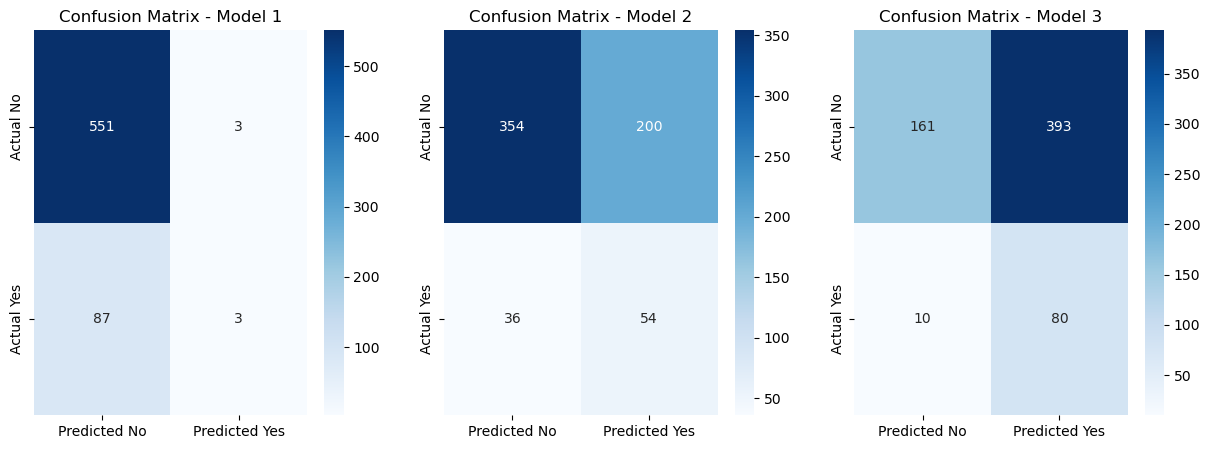

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_df_v1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Model 1')

sns.heatmap(cm_df_v2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Model 2')

sns.heatmap(cm_df_v3, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix - Model 3')

plt.show()


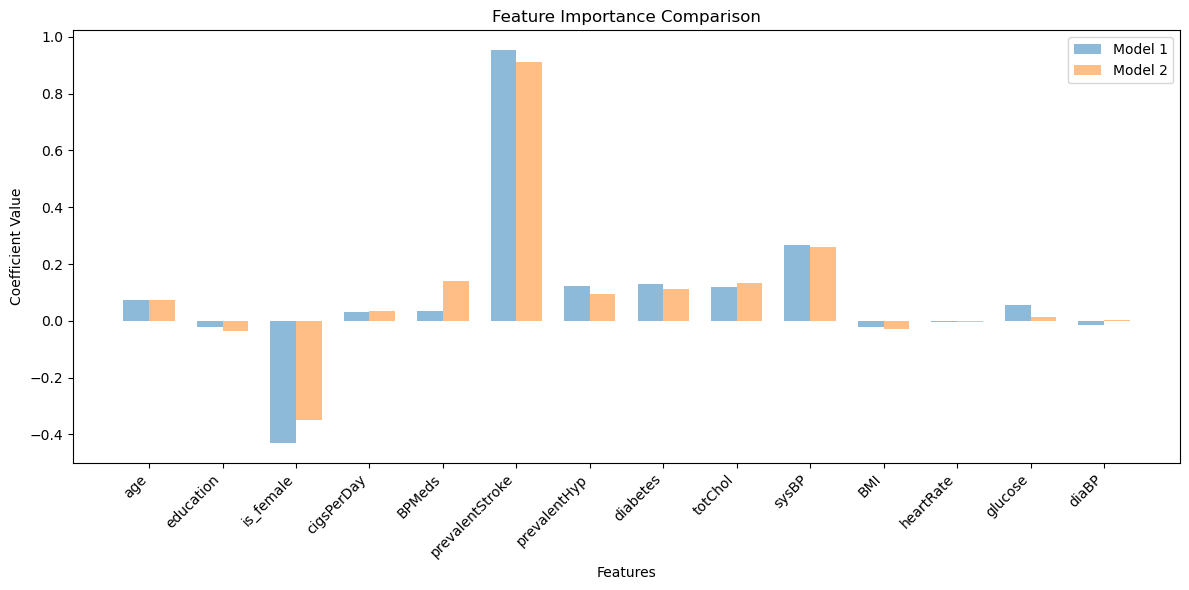

In [53]:
coef_1 = log_reg_v1.coef_.flatten()
coef_2 = log_reg_v2.coef_.flatten()

features = X_train.columns

x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, coef_1, width, label='Model 1', alpha=0.5)
bars2 = ax.bar(x + width/2, coef_2, width, label='Model 2', alpha=0.5)

ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.set_title('Feature Importance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()

Coefficients are similar between Model 1 and Model 2. Balancing the class weights helped improve the model’s sensitivity to detecting CHD without drastically changing feature importance.
There are slight differences in sex and Stroke coefficients, it suggests that balancing the class weights caused the model to re-evaluate the importance of certain features, focusing more on those that help detect positive cases.
Model 3 uses the same logistic regression model as Model 2 but with an adjusted threshold. As the model coefficients will be the same for both Models 2 and 3, plotting them again won't show any additional insights.

ROC AUC and curves for all three models

ROC AUC (Model 1): 0.689
ROC AUC (Model 2): 0.685
ROC AUC (Model 3): 0.685


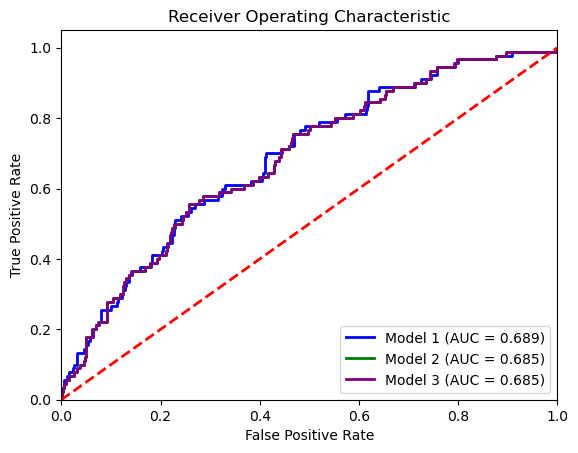

In [ ]:
y_pred_prob_v1 = log_reg_v1.predict_proba(X_test)[:, 1]
roc_auc_v1 = roc_auc_score(y_test, y_pred_prob_v1)
print(f"ROC AUC (Model 1): {roc_auc_v1:.3f}")

y_pred_prob_v2 = log_reg_v2.predict_proba(X_test)[:, 1]
roc_auc_v2 = roc_auc_score(y_test, y_pred_prob_v2)
print(f"ROC AUC (Model 2): {roc_auc_v2:.3f}")

y_prob_3 = log_reg_v2.predict_proba(X_test)[:, 1]
roc_auc_v3 = roc_auc_score(y_test, y_prob_3)
print(f"ROC AUC (Model 3): {roc_auc_v3:.3f}")

fpr_v1, tpr_v1, _ = roc_curve(y_test, y_pred_prob_v1)
fpr_v2, tpr_v2, _ = roc_curve(y_test, y_pred_prob_v2)
fpr_v3, tpr_v3, _ = roc_curve(y_test, y_prob_3)

plt.figure()
plt.plot(fpr_v1, tpr_v1, color='blue', lw=2, label=f'Model 1 (AUC = {roc_auc_v1:.3f})')
plt.plot(fpr_v2, tpr_v2, color='green', lw=2, label=f'Model 2 (AUC = {roc_auc_v2:.3f})')
plt.plot(fpr_v3, tpr_v3, color='purple', lw=2, label=f'Model 3 (AUC = {roc_auc_v3:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Model 1 ROC AUC: 0.689 - Moderate discrimination between classes.

Model 2 and Model 3 ROC AUC: 0.685 - Similar discrimination as Model 1. Adjusting for class imbalance and threshold does not significantly affect the score.

### Conclusions
Model 1: Base Logistic Regression
- Strengths: Excellent at predicting the absence of CHD (Class 0), with high precision and recall for "No."
- Weaknesses: Struggles to predict CHD presence (Class 1), with very low recall for "Yes," resulting in missed diagnoses.

Model 2: Balanced Class Weights
- Strengths: Improves recall for CHD presence (Class 1) to 0.60, making it better at detecting positive cases.
- Weaknesses: Low precision for "Yes" (many false positives), and accuracy drops due to the class imbalance correction.

Model 3: Adjusted Threshold (0.3)
- Strengths: Maximizes recall for CHD presence (0.89), highly sensitive to detecting positive cases.
- Weaknesses: Precision for "Yes" drops significantly (0.17), leading to many false positives, and accuracy decreases to 0.37.

### Recommendations for futher analyses:
- Model 2 (Balanced Weights): For further analysis, adjusting class weights or hyperparameters (e.g., C) could help better balance recall and precision.
- Model 3 (Adjusted Threshold): Exploring thresholds between 0.3 and 0.5 might improve the balance between recall and precision.
- Alternative Models: Other algorithms, like tree-based models (Random Forest, Gradient Boosting), could be tested for potentially better results on imbalanced datasets.
- Precision-Recall Focus: F1-score could be prioritized over accuracy to better balance precision and recall.
- Feature Engineering: Exploring techniques like oversampling or undersampling might enhance model performance.
- Domain Evaluation: Further consultation with domain experts may ensure the model’s predictions are aligned with practical requirements.